## Import dependencies

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import torch
from torchvision import transforms, utils
from PIL import Image
import math
import random
import os

import numpy as np
import matplotlib.pyplot as plt

import mlflow
from mlflow.models import infer_signature

from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
from copy import deepcopy
from dotenv import load_dotenv

# Install user-defined packages
from utils.model import *
from utils.e4e_projection import projection as e4e_projection
from utils.util import *


/media/minhnhk/HDD/learn/jojogan_zombie/.venv/lib/python3.9/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/media/minhnhk/HDD/learn/jojogan_zombie/.venv/lib/python3.9/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/media/minhnhk/HDD/learn/jojogan_zombie/.venv/lib/python3.9/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/media/minhnhk/HDD/learn/jojogan_zombie/.venv/lib/python3.9/site-packages/torch/utils/cpp_exte

## Setting CUDA and CUDNN configuration

In [3]:
# Setting Cudnn benchmark usage for PyTorch
torch.backends.cudnn.benchmark = True

In [4]:
# Please change it to CPU if you do not have GPU
device = 'cuda' # 'cuda' or 'cpu'

## Setting the directories

In [33]:
# Construct the path to the directory in the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Set the sub-directory paths
models_dir = os.path.join(parent_dir, "models")
ref_dir = os.path.join(parent_dir, "data", "ref")
ref_aligned_dir = os.path.join(parent_dir, "data", "ref_aligned")
src_dir = os.path.join(parent_dir, "data", "src")
out_dir = os.path.join(parent_dir, "data", "out")

## Download pretrained model

In [10]:
drive_ids = {
    "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
    "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
    "restyle_psp_ffhq_encode.pt": "1nbxCIVw9H3YnQsoIPykNEFwWJnHVHlVd",
    "arcane_caitlyn.pt": "1gOsDTiTPcENiFOrhmkkxJcTURykW1dRc",
    "arcane_caitlyn_preserve_color.pt": "1cUTyjU-q98P75a8THCaO545RTwpVV-aH",
    "arcane_jinx_preserve_color.pt": "1jElwHxaYPod5Itdy18izJk49K1nl4ney",
    "arcane_jinx.pt": "1quQ8vPjYpUiXM4k1_KIwP4EccOefPpG_",
    "arcane_multi_preserve_color.pt": "1enJgrC08NpWpx2XGBmLt1laimjpGCyfl",
    "arcane_multi.pt": "15V9s09sgaw-zhKp116VHigf5FowAy43f",
    "sketch_multi.pt": "1GdaeHGBGjBAFsWipTL0y-ssUiAqk8AxD",
    "disney.pt": "1zbE2upakFUAx8ximYnLofFwfT8MilqJA",
    "disney_preserve_color.pt": "1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi",
    "jojo.pt": "13cR2xjIBj8Ga5jMO7gtxzIJj2PDsBYK4",
    "jojo_preserve_color.pt": "1ZRwYLRytCEKi__eT2Zxv1IlV6BGVQ_K2",
    "jojo_yasuho.pt": "1grZT3Gz1DLzFoJchAmoj3LoM9ew9ROX_",
    "jojo_yasuho_preserve_color.pt": "1SKBu1h0iRNyeKBnya_3BBmLr4pkPeg_L",
    "art.pt": "1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT",
}

# Construct the path to the directory in the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
models_dir = os.path.join(parent_dir, "models")

# from StyelGAN-NADA
class Downloader(object):
    def download_file(self, file_name):
        file_dst = os.path.join(models_dir, file_name)
        file_id = drive_ids[file_name]
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            !gdown --id $file_id -O $file_dst

downloader = Downloader()
downloader.download_file('stylegan2-ffhq-config-f.pt')
downloader.download_file('e4e_ffhq_encode.pt')

stylegan2_path = os.path.join(models_dir, "stylegan2-ffhq-config-f.pt")

## Loading pretrained model

In [11]:
latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load(stylegan2_path, map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)

transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

## Source Image Setup to extract Face

Loading e4e over the pSp framework from checkpoint: ../models/e4e_ffhq_encode.pt


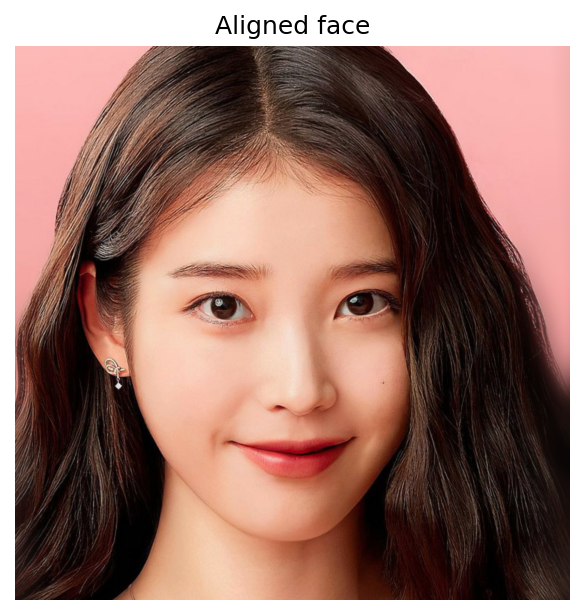

In [12]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

#@title Choose input face
#@markdown Add your own image to the test_input directory and put the name here

filename = 'iu.jpeg' #@param {type:"string"}

filepath = os.path.join(src_dir, filename)

# aligns and crops face from the source image
aligned_face = align_face(filepath)

# my_w = reref_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, device).unsqueeze(0)

display_image(aligned_face, title='Aligned face')

In [13]:
plt.rcParams['figure.dpi'] = 150
pretrained = 'sketch_multi' #@param ['art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney']
#@markdown Preserve color tries to preserve color of original image by limiting family of allowable transformations. Otherwise, the stylized image will inherit the colors of the reference images, leading to heavier stylizations.
preserve_color = True #@param{type:"boolean"}

if preserve_color:
    ckpt = f'{pretrained}_preserve_color.pt'
else:
    ckpt = f'{pretrained}.pt'

# load base version if preserve_color version not available
try:
    downloader.download_file(ckpt)
except:
    ckpt = f'{pretrained}.pt'
    downloader.download_file(ckpt)

In [14]:
ckpt = torch.load(os.path.join(models_dir, ckpt), map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g"], strict=False)

<All keys matched successfully>

In [15]:
#@title Generate results
n_sample =  6#@param {type:"number"}
seed = 3000 #@param {type:"number"}

torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

/media/minhnhk/HDD/learn/jojogan_zombie/notebooks/../utils/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.6.0+cu126. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


In [16]:
# display reference images
if pretrained == 'arcane_multi':
    style_path = os.path.join(ref_aligned_dir, 'arcane_jinx.png')
elif pretrained == 'sketch_multi':
    style_path = os.path.join(ref_aligned_dir, 'sketch.png')
else:
    style_path = os.path.join(ref_aligned_dir, f'{pretrained}.png')

In [17]:
style_image = transform(Image.open(style_path)).unsqueeze(0).to(device)
face = transform(aligned_face).unsqueeze(0).to(device)

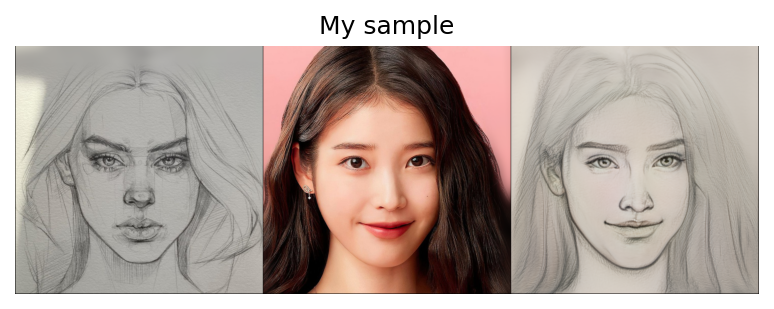

In [18]:
my_output = torch.cat([style_image, face, my_sample], 0)
my_output.shape
display_image(utils.make_grid(my_output, normalize=True), title='My sample')

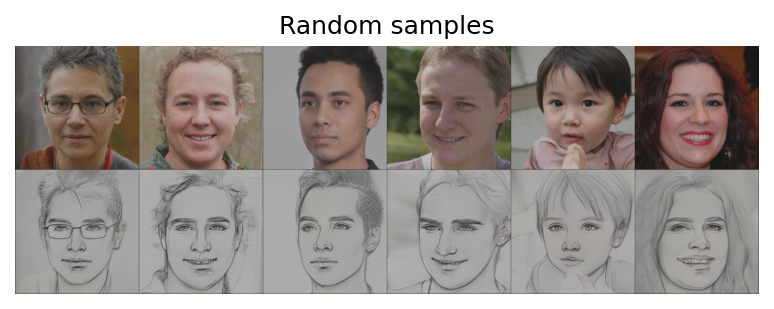

In [19]:
%matplotlib inline
output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, nrow=n_sample), title='Random samples')

## Stylize Zombie face

### Set tracking URL and environment variables

In [20]:
mlflow.set_tracking_uri('http://localhost:5000')

load_dotenv("../mlflow-docker-compose/.env")
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9000"  # Replace it with your endpoint URL of MLFLOW
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

In [21]:
try:
    mlflow.set_experiment("JoJoGAN_Zombie")
except:
    pass

mlflow.set_experiment("JoJoGAN_Zombie")

<Experiment: artifact_location='s3://mlflow/11', creation_time=1738813479549, experiment_id='11', last_update_time=1738813479549, lifecycle_stage='active', name='JoJoGAN_Zombie', tags={}>

### Zombie Referenced Image

In [22]:
# List of reference images
names = ["zombie.jpg"]
targets = []
latents = []

# Latent space create from the styles

for name in names:
    style_path = os.path.join(ref_dir, name)
    assert os.path.exists(style_path), f"{style_path} does not exist!"

    name = strip_path_extension(name)

    # crop and align the face
    style_aligned_path = os.path.join(ref_aligned_dir, f'{name}.png')
    if not os.path.exists(style_aligned_path):
        style_aligned = align_face(style_path)
        style_aligned.save(style_aligned_path)
    else:
        style_aligned = Image.open(style_aligned_path).convert('RGB')

    # GAN invert
    style_code_path = os.path.join('../models/inversion_codes', f'{name}.pt')
    if not os.path.exists(style_code_path):
        latent = e4e_projection(style_aligned, style_code_path, device)
    else:
        latent = torch.load(style_code_path)['latent']

    targets.append(transform(style_aligned).to(device))
    latents.append(latent.to(device))

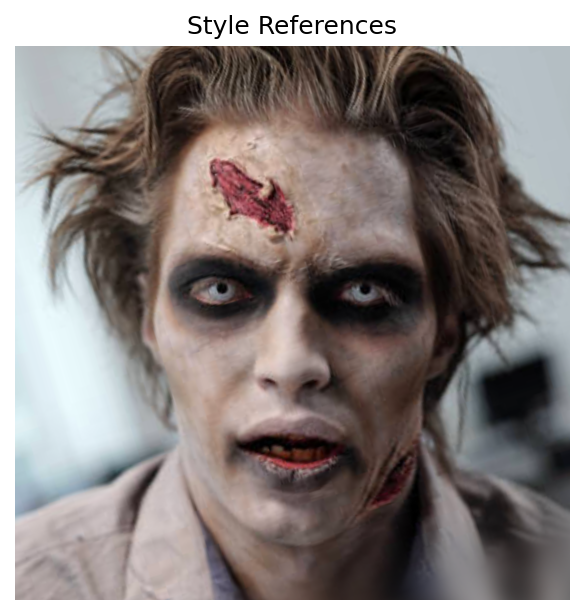

In [23]:
%matplotlib inline

targets = torch.stack(targets, 0)
latents = torch.stack(latents, 0)

target_im = utils.make_grid(targets, normalize=True)
display_image(target_im, title='Style References')

### Finetune Style GAN

In [35]:
#@title Finetune StyleGAN

#@markdown alpha controls the strength of the style
alpha =  0.7 #@param {type:"slider", min:0, max:1, step:0.1}
alpha = 1 - alpha
#@markdown Tries to preserve color of original image by limiting family of allowable transformations. Set to false if you want to transfer color from reference image. This also leads to heavier stylization
preserve_color = False #@param{type:"boolean"}
#@markdown Number of finetuning steps. Different style reference may require different iterations. Try 200~500 iterations.
num_iter = 500 #@param {type:"number"}
#@markdown interval for image logging
log_interval = 50 #@param {type:"number"}
# Generate the output images
n_sample =  6#@param {type:"number"}
seed = 3000 #@param {type:"number"}

# specify params
params = {
    "alpha": alpha,
    "preserve_color": preserve_color,
    "num_iter": num_iter,
    "log_interval": log_interval,
    "lr": 4e-3,
    "betas": (0.0, 0.99),
}

# load discriminator for perceptual loss
discriminator = Discriminator(1024, 2).eval().to(device)
ckpt = torch.load('../models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
discriminator.load_state_dict(ckpt["d"], strict=False)

# reset generator
del generator
generator = deepcopy(original_generator)

g_optim = optim.Adam(generator.parameters(), lr=2e-3, betas=(0.0, 0.99))

# Which layers to swap for generating a family of plausible real images -> fake image
if preserve_color:
    id_swap = [9,11,15,16,17]
else:
    id_swap = list(range(7, generator.n_latent))

training_loss = []

with mlflow.start_run():
    for idx in tqdm(range(num_iter)):
        mean_w = generator.get_latent(torch.randn([latents.size(0), latent_dim]).to(device)).unsqueeze(1).repeat(1, generator.n_latent, 1)
        in_latent = latents.clone()
        in_latent[:, id_swap] = alpha*latents[:, id_swap] + (1-alpha)*mean_w[:, id_swap]

        img = generator(in_latent, input_is_latent=True)

        with torch.no_grad():
            real_feat = discriminator(targets)
        fake_feat = discriminator(img)

        loss = sum([F.l1_loss(a, b) for a, b in zip(fake_feat, real_feat)])/len(fake_feat)

        training_loss.append(loss.item())
        mlflow.log_metric("loss", loss.item(), step=idx)
        
        g_optim.zero_grad()
        loss.backward()
        g_optim.step()

    # Log the parameters
    mlflow.log_params(params)

    # Log generator model to MLFlow
    mlflow.pytorch.log_model(generator, "models")

    torch.manual_seed(seed)
    with torch.no_grad():
        generator.eval()
        z = torch.randn(n_sample, latent_dim, device=device)

        # My image
        my_sample = generator(my_w, input_is_latent=True)
        # Save image to disk
        utils.save_image(my_output, os.path.join(out_dir, 'zombie_' + filename), normalize=True)

        # Random images
        sample = generator([z], truncation=0.7, truncation_latent=mean_latent)
        # Save image to disk
        utils.save_image(sample, os.path.join(out_dir, f'zombie_samples.png'), normalize=True)
        
        mlflow.log_artifact(os.path.join(out_dir, 'zombie_' + filename))
        mlflow.log_artifact(os.path.join(out_dir, f'zombie_samples.png'))


  0%|          | 0/500 [00:00<?, ?it/s]/media/minhnhk/HDD/learn/jojogan_zombie/notebooks/../utils/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.6.0+cu126. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
100%|██████████| 500/500 [01:02<00:00,  8.02it/s]
2025/02/06 14:24:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/02/06 14:24:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp76y7r0qn/model/data, flavor: pytorch). Fall back to return ['torch==2.6.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/02/06 14:24:31 WARNING m

🏃 View run salty-cod-93 at: http://localhost:5000/#/experiments/11/runs/b1b5d9e58ef64eff9451535cec6d3cc6
🧪 View experiment at: http://localhost:5000/#/experiments/11


### Display Tranformed image

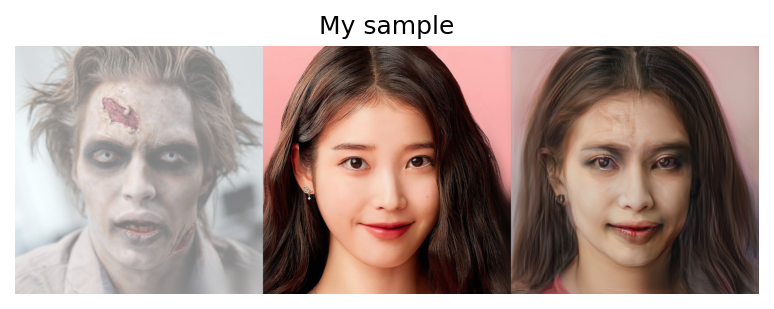

In [25]:
%matplotlib inline
my_output = torch.cat([target_im, face[0], my_sample[0]], 2)
display_image(utils.make_grid(my_output, normalize=True), title='My sample')

### Display Transformed images using Random Faces from the Faces Dataset

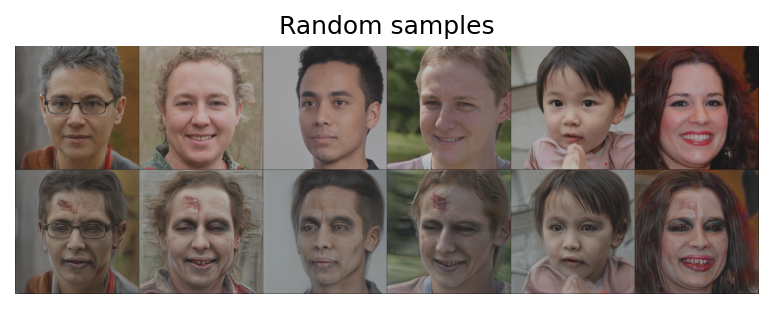

In [26]:
output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, nrow=n_sample), title='Random samples')

## Save Model and Load Model

Basically, MLFlow help us to log the models, metrics, artifact,... So we do not need to save it to somewhere else.

We just use the load function `mlflow.pytorch.load_model()`.

Remember before exporting the official model, you need to choose the best model first on the mlflow UI.

In [93]:
model_name = "jojogan-zombie"
# Choose the last model registered
model_version = "latest"

# Load the model from the Model Registry
model_uri = f"models:/{model_name}/{model_version}"
model = mlflow.pytorch.load_model(model_uri)

/media/minhnhk/HDD/learn/jojogan_zombie/.venv/lib/python3.9/site-packages/mlflow/store/artifact/utils/models.py:31: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


In [95]:
# Save the dictionary of torch model
torch.save(model.state_dict(), os.path.join(models_dir, f"{model_name}.pt"))

In [96]:
latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load(stylegan2_path, map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
loaded_generator = deepcopy(original_generator)
loaded_generator.load_state_dict(torch.load(os.path.join(models_dir, 'zombie.pt')))

<All keys matched successfully>

In [97]:
filename = 'chris.jpeg' #@param {type:"string"}

filepath = os.path.join(src_dir, filename)

# aligns and crops face from the source image
aligned_face = align_face(filepath)

# my_w = reref_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, device).unsqueeze(0)

Loading e4e over the pSp framework from checkpoint: ../models/e4e_ffhq_encode.pt


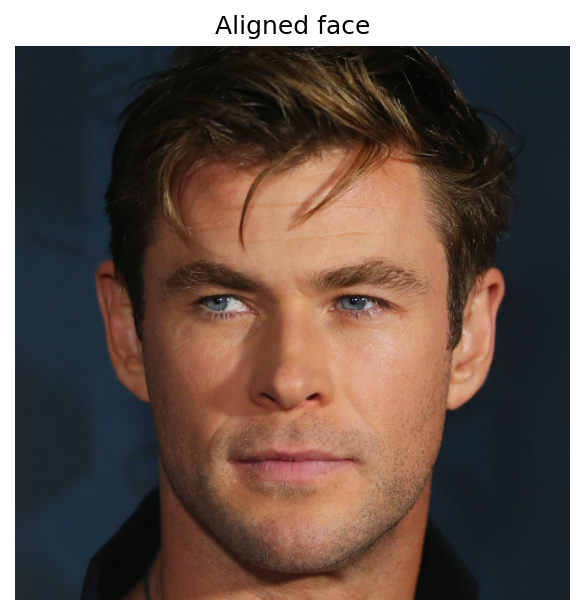

In [ ]:
%matplotlib inline
display_image(aligned_face, title='Aligned face')

In [101]:
with torch.no_grad():
    model.eval()
    my_sample = model(my_w, input_is_latent=True)

/media/minhnhk/HDD/learn/jojogan_zombie/notebooks/../utils/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.6.0+cu126. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


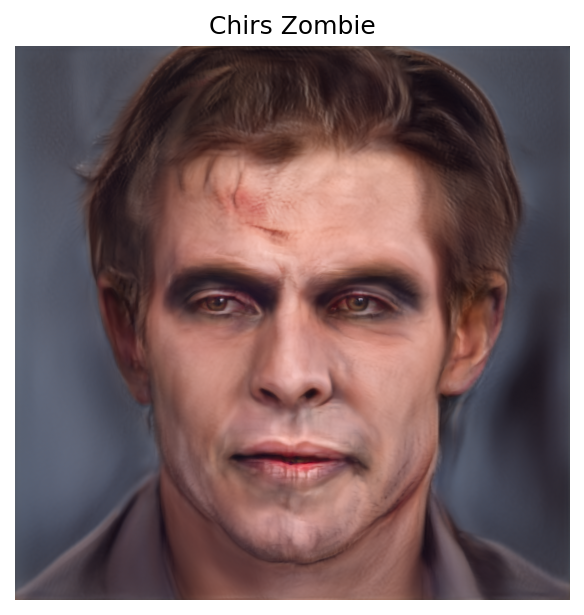

In [102]:
display_image(utils.make_grid(my_sample, normalize=True), title='Chirs Zombie')